In [1]:
# Source: Alexandru Tifrea and Fanny Yang, 2021.
# Based on an earlier version by Sebastian Curi and Andreas Krause.

# Python Notebook Commands
%reload_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# General math and plotting modules.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Widget and formatting modules
import ipywidgets
from ipywidgets import interact, interactive, interact_manual, fixed, widgets
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 6)
rcParams['font.size'] = 16

# Machine Learning library.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import datasets

import warnings

rcParams['figure.figsize'] = (15, 6)
rcParams['font.size'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Kernel Ridge Regression

### Regression with polynomial kernels

In the following we show how the estimator depends on hyperparameters like the ridge coefficient or the the degree of the polynomial used for to define the kernel.


Let's consider 1-dimensional data $\{(x_i, y_i)\}_{i=0}^n \subset \mathbb{R} \times \mathbb{R}$. We use a polynomial kernel of the form $k(x, z)=1 + xz + (xz)^2+...+(xz)^d$ for the regression task. This kernel induces a feature representation of the data in the space of monomials of degree at most $d$, i.e. $\varphi: \mathbb{R} \rightarrow span(\{1, X, X^2, ..., X^d\})$. Minimizing the kernel regression objective is equivalent to performing linear regression in this feature space. The maximum degree controls the complexity of the kernel function.

The kernel ridge regression that is minimized below can be written as: $L(w; \lambda) := \sum_{i=0}^n (y_i - w^T\varphi(x_i))^2 + \lambda ||w||_2^2 $

In [89]:
def true_regression_fun(X):
    return np.cos(3 * np.pi * X)


def poly_kernel_regression(n_samples, degree, l2_coef, noise):
    np.random.seed(101)

    X = np.sort(np.random.rand(n_samples))
    y = true_regression_fun(X) + np.random.randn(n_samples) * noise

    clf = make_pipeline(
        PolynomialFeatures(degree),
        Ridge(alpha=l2_coef, fit_intercept=False, solver="svd"))
    clf.fit(X[:, np.newaxis], y)

    X_test = np.linspace(0 - 1e-4, 1 + 1e-4, 100)
    fig = make_subplots(rows=2, cols=1, row_width=[0.15, 0.35])
    fig.add_trace(go.Scatter(x=X_test,
                             y=clf.predict(X_test[:, np.newaxis]),
                             line_width=3,
                             name="Model"),
                  row=1,
                  col=1)
    fig.add_trace(go.Scatter(x=X_test,
                             y=true_regression_fun(X_test),
                             line_dash="dash",
                             line_width=3,
                             name="True function"),
                  row=1,
                  col=1)
    fig.add_trace(go.Scatter(x=X,
                             y=y,
                             mode="markers",
                             marker_size=7,
                             marker_symbol="x",
                             marker_color="black",
                             name="Samples"),
                  row=1,
                  col=1)
    fig.add_trace(go.Scatter(x=np.arange(clf["ridge"].coef_.shape[0]),
                             y=np.fabs(clf["ridge"].coef_),
                             line_width=3,
                             showlegend=False),
                  row=2,
                  col=1)

    fig.update_layout(
        margin=go.layout.Margin(
            l=0,  #left margin
            r=0,  #right margin
            b=0,  #bottom margin
            t=0,  #top margin
        ),
        xaxis1_range=[0, 1],
        xaxis1_title="x",
        yaxis1_range=[-2, 2],
        yaxis1_title="y",
        xaxis2_title="Degree",
        yaxis2_title="Abs. value of coefficient",
    )
    fig.show()


_ = interact(
    poly_kernel_regression,
    n_samples=ipywidgets.IntSlider(value=20,
                                   min=5,
                                   max=100,
                                   step=5,
                                   description='Number of samples:',
                                   style={'description_width': 'initial'},
                                   continuous_update=False),
    degree=ipywidgets.IntSlider(value=10,
                                min=1,
                                max=30,
                                step=1,
                                description='Polynomial Degree:',
                                style={'description_width': 'initial'},
                                continuous_update=False),
    l2_coef=ipywidgets.FloatSlider(value=0.,
                                   min=0,
                                   max=0.001,
                                   step=0.0001,
                                   readout_format='.4f',
                                   description='Ridge coefficient:',
                                   style={'description_width': 'initial'},
                                   continuous_update=False),
    noise=ipywidgets.FloatSlider(value=0.5,
                                 min=0,
                                 max=1,
                                 step=0.1,
                                 readout_format='.2f',
                                 description='Noise level:',
                                 style={'description_width': 'initial'},
                                 continuous_update=False),
)

interactive(children=(IntSlider(value=20, continuous_update=False, description='Number of samples:', min=5, st…

### Regression with RBF kernels

In the following we show how the estimator depends on hyperparameters like the ridge coefficient or the bandwidth for two commonly used radial basis function (RBF) kernels: the Gaussian and the Laplacian kernels. RBF kernels differ from polynomial kernels in that they induce a feature map from the inputs to an infinite-dimensional space.

The general form of RBF kernels is $k(x, z) = \exp\left( \frac{|x-z|^p}{\sigma}\right)$; for $p=1$ and $p=2$ we recover the Laplacian and the Gaussian kernel, respectively. The bandwidth $\sigma$ controls the smoothness of prediction function.

In [135]:
suppress_update = False

from sklearn.svm import SVR

def rbf_kernel_regression(kernel, n_samples, bandwidth, l2_coef, noise):
    global suppress_update
    if suppress_update:
        return

    # Set different bandwidth ranges for Laplacian and Gaussian kernels.
#     if kernel_w.value == "Laplacian":
#         suppress_update = True
# #         bandwidth_w.max = 15
#         bandwidth_w.max = 3
#         suppress_update = False
#         bandwidth_w.min = -3
# #         bandwidth_w.min = 9
#     else:
#         suppress_update = True
#         bandwidth_w.min = -3
#         bandwidth_w.max = 5
#         suppress_update = False

    np.random.seed(11)
    X = np.sort(np.random.rand(n_samples))
    y = true_regression_fun(X) + np.random.randn(n_samples) * noise

    gamma = np.power(10., -bandwidth)
    print(gamma)
    if kernel == 'Gaussian':
        kernel = "rbf"
    elif kernel == 'Laplacian':
#         l2_coef *= 1e-6
        kernel = "laplacian"
#         kernel = lambda X, Y: laplacian_kernel(X, Y, gamma)

    with warnings.catch_warnings():
        #         warnings.simplefilter('ignore')
        clf = KernelRidge(alpha=l2_coef, kernel=kernel, gamma=gamma)
#         clf = svm.SVR(C=np.power(10., -l2_coef), kernel=kernel, gamma=gamma)
        clf.fit(X[:, np.newaxis], y)

    X_test = np.linspace(0 - 1e-4, 1 + 1e-4, 100)
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=X_test,
                   y=clf.predict(X_test[:, np.newaxis]),
                   line_width=3,
                   name="Model"))
    fig.add_trace(
        go.Scatter(x=X_test,
                   y=true_regression_fun(X_test),
                   line_dash="dash",
                   line_width=3,
                   name="True function"))
    fig.add_trace(
        go.Scatter(x=X,
                   y=y,
                   mode="markers",
                   marker_size=7,
                   marker_symbol="x",
                   marker_color="black",
                   name="Samples"))

    fig.update_layout(
        margin=go.layout.Margin(
            l=0,  #left margin
            r=0,  #right margin
            b=0,  #bottom margin
            t=0,  #top margin
        ),
        xaxis_range=[0, 1],
        xaxis_title="x",
        yaxis_range=[-2, 2],
        yaxis_title="y",
    )
    fig.show()

kernel_w = ipywidgets.Dropdown(
    options=['Gaussian', 'Laplacian'],
    #                                value="Gaussian",
    value="Laplacian",
    description="Kernel:",
    style={'description_width': 'initial'},
    continuous_update=False)
bandwidth_w = ipywidgets.FloatSlider(value=-1,
                                     min=-3,
                                     max=5,
                                     step=0.1,
                                     readout_format='.1f',
                                     description='Bandwidth 10^:',
                                     style={'description_width': 'initial'},
                                     continuous_update=False)
l2_coef = ipywidgets.FloatSlider(value=0.,
                                 min=0,
                                 max=0.0001,
                                 step=0.00001,
                                 readout_format='.5f',
                                 description='Ridge coefficient:',
                                 style={'description_width': 'initial'},
                                 continuous_update=False)

_ = interact(
    rbf_kernel_regression,
    kernel=kernel_w,
    bandwidth=bandwidth_w,
    n_samples=ipywidgets.IntSlider(value=30,
                                   min=10,
                                   max=100,
                                   step=10,
                                   description='Number of samples:',
                                   style={'description_width': 'initial'},
                                   continuous_update=False),
    l2_coef=l2_coef,
    noise=ipywidgets.FloatSlider(value=0.1,
                                 min=0,
                                 max=1,
                                 step=0.01,
                                 readout_format='.2f',
                                 description='Noise level:',
                                 style={'description_width': 'initial'},
                                 continuous_update=False),
)

interactive(children=(Dropdown(description='Kernel:', index=1, options=('Gaussian', 'Laplacian'), style=Descri…

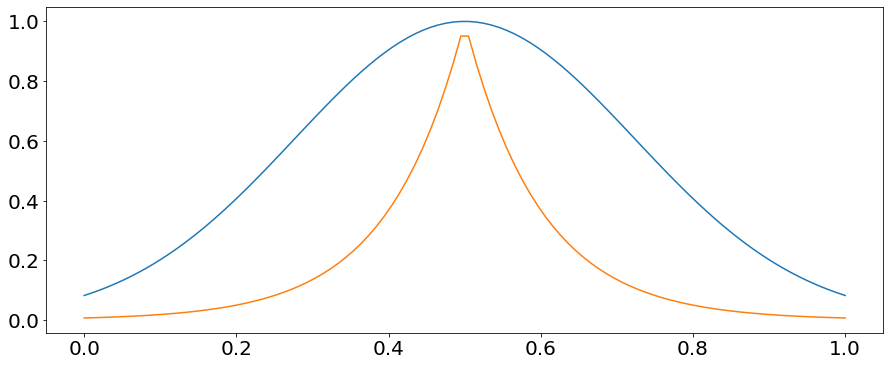

In [158]:
from sklearn.metrics.pairwise import pairwise_kernels

np.random.seed(101)
n_samples = 10
x = np.linspace(0, 1, 100).reshape(-1, 1)
x0 = 0.5
gamma = 1e1
g = pairwise_kernels(X=x, Y=[[x0]], metric="rbf", gamma=gamma)
l = pairwise_kernels(X=x, Y=[[x0]], metric="laplacian", gamma=gamma)

plt.plot(x, g)
plt.plot(x, l)

# RBF kernel classification with SVMs

In [90]:
# Our dataset and targets
n_samples = 20  # Number of points per class
tol = 1e-1


def laplacian_kernel(X, Y, gamma):
    rows = X.shape[0]
    cols = Y.shape[0]
    K = np.zeros((rows, cols))
    for col in range(cols):
        dist = gamma * np.linalg.norm(X - Y[col, :], ord=1, axis=1)
        K[:, col] = np.exp(-dist)
    return K


def kernelized_svm(dataset, kernel, reg, bw, noise):
    if dataset == 'blobs':
        X, Y = datasets.make_blobs(n_samples=n_samples,
                                   centers=2,
                                   random_state=3,
                                   cluster_std=10 * noise)
    elif dataset == 'circles':
        X, Y = datasets.make_circles(n_samples=n_samples,
                                     factor=.5,
                                     noise=noise,
                                     random_state=42)
    elif dataset == 'moons':
        X, Y = datasets.make_moons(n_samples=n_samples,
                                   noise=noise,
                                   random_state=42)
    elif dataset == 'xor':
        np.random.seed(42)
        step = int(n_samples / 4)

        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples)

        X[0 * step:1 * step, :] = noise * np.random.randn(step, 2)
        Y[0 * step:1 * step] = 1
        X[1 * step:2 *
          step, :] = np.array([1, 1]) + noise * np.random.randn(step, 2)
        Y[1 * step:2 * step] = 1

        X[2 * step:3 *
          step, :] = np.array([0, 1]) + noise * np.random.randn(step, 2)
        Y[2 * step:3 * step] = -1
        X[3 * step:4 *
          step, :] = np.array([1, 0]) + noise * np.random.randn(step, 2)
        Y[3 * step:4 * step] = -1

    elif dataset == 'periodic':
        np.random.seed(42)
        step = int(n_samples / 4)

        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples)

        X[0 * step:1 * step, :] = noise * np.random.randn(step, 2)
        Y[0 * step:1 * step] = 1
        X[1 * step:2 *
          step, :] = np.array([0, 2]) + noise * np.random.randn(step, 2)
        Y[1 * step:2 * step] = 1

        X[2 * step:3 *
          step, :] = np.array([0, 1]) + noise * np.random.randn(step, 2)
        Y[2 * step:3 * step] = -1
        X[3 * step:4 *
          step, :] = np.array([0, 3]) + noise * np.random.randn(step, 2)
        Y[3 * step:4 * step] = -1

    X = X[Y <= 1, :]
    Y = Y[Y <= 1]
    Y[Y == 0] = -1

    # Add the 1 feature.
    X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    plot_support = False
    gamma = np.power(10., -bw)
    coef0 = 0
    if kernel == 'Gaussian':
        kernel = "rbf"
    elif kernel == 'Laplacian':
        kernel = lambda X, Y: laplacian_kernel(X, Y, gamma)
        plot_support = False

    classifier = svm.SVC(kernel=kernel,
                         C=np.power(10., -reg),
                         gamma=gamma,
                         coef0=coef0,
                         tol=tol)
    classifier.fit(X, Y)

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure()
    plt.clf()
    fig = plt.axes()
    opt = {'marker': 'r*', 'label': '+'}
    plot_data(X[np.where(Y == 1)[0], 0],
              X[np.where(Y == 1)[0], 1],
              fig=fig,
              options=opt)
    opt = {'marker': 'bo', 'label': '-'}
    plot_data(X[np.where(Y == -1)[0], 0],
              X[np.where(Y == -1)[0], 1],
              fig=fig,
              options=opt)

    if plot_support:
        plt.scatter(classifier.support_vectors_[:, 0],
                    classifier.support_vectors_[:, 1],
                    s=80,
                    facecolors='none',
                    edgecolors='k')

    mins = np.min(X, 0)
    maxs = np.max(X, 0)
    x_min = mins[0] - 1
    x_max = maxs[0] + 1
    y_min = mins[1] - 1
    y_max = maxs[1] + 1

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Xtest = np.c_[XX.ravel(), YY.ravel(), np.ones_like(XX.ravel())]
    Z = classifier.decision_function(Xtest)

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.contourf(XX, YY, Z > 0, cmap=plt.cm.jet, alpha=0.3)
    plt.contour(XX,
                YY,
                Z,
                colors=['k', 'k', 'k'],
                linestyles=['-'],
                levels=[0])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)


def plot_data(X, Y, fig=None, options=dict()):
    fig.plot(X,
             Y,
             options.get('marker', 'b*'),
             label=options.get('label', 'Raw data'),
             fillstyle=options.get('fillstyle', 'full'),
             ms=options.get('size', 10))


_ = interact(
    kernelized_svm,
    dataset=['blobs', 'circles', 'moons', 'xor', 'periodic'],
    kernel=['Gaussian', 'Laplacian'],
    reg=ipywidgets.FloatSlider(value=-3,
                               min=-3,
                               max=3,
                               step=0.5,
                               readout_format='.1f',
                               description='Regularization 10^:',
                               style={'description_width': 'initial'},
                               continuous_update=False),
    bw=ipywidgets.FloatSlider(value=-1,
                              min=-3,
                              max=3,
                              step=0.1,
                              readout_format='.1f',
                              description='Bandwidth 10^:',
                              style={'description_width': 'initial'},
                              continuous_update=False),
    noise=ipywidgets.FloatSlider(value=0.05,
                                 min=0.01,
                                 max=0.3,
                                 step=0.01,
                                 readout_format='.2f',
                                 description='Noise level:',
                                 style={'description_width': 'initial'},
                                 continuous_update=False),
)

interactive(children=(Dropdown(description='dataset', options=('blobs', 'circles', 'moons', 'xor', 'periodic')…